# Statistics and Machine Learning

Some operations are especially useful for statistics

- `get_dummies`
- Categoricals
- `sample`


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 6
pd.options.display.max_columns = 6

It's quite common to have categorical data (in the statistical sense), which must be transformed before putting them into an algorithm. There are a couple ways to handle this.

### Categoricals

This basically creates a mapping between the categories and integers. This sometimes makes sense if you're representing something like responses to a survey where the responses are `bad`, `neutral` and `good`.

In [4]:
np.random.seed(27)
s = pd.Series(np.random.choice(['bad', 'neutral', 'good'], size=40))
s

0         bad
1         bad
2         bad
       ...   
37        bad
38        bad
39    neutral
dtype: object

In [5]:
np.random.seed(27)
s = pd.Series(pd.Categorical(np.random.choice(['bad', 'neutral', 'good'], size=40),
                             categories=['bad', 'neutral', 'good'], ordered=True))
s

0         bad
1         bad
2         bad
       ...   
37        bad
38        bad
39    neutral
dtype: category
Categories (3, object): [bad < neutral < good]

Categoricals can put inside Series or DataFrames just like any other column. The have a
a special `.cat` namespace.

In [6]:
s.cat.categories

Index([u'bad', u'neutral', u'good'], dtype='object')

In [7]:
s.cat.codes

0     0
1     0
2     0
     ..
37    0
38    0
39    1
dtype: int8

In [8]:
df = pd.concat([pd.DataFrame(np.random.randn(40, 3), columns=list('abc')),
                s],
               axis=1)
df

,a,b,c,0
0,0.371535,-1.335292,0.158730,bad
1,-0.484234,-0.829893,0.669012,bad
2,0.036602,1.026895,1.042563,bad
...,...,...,...,...
37,0.620891,1.151247,-0.158203,bad
38,0.071992,0.574698,-0.603291,bad
39,0.298054,1.214289,-0.625867,neutral


# Dummies

In [9]:
s

0         bad
1         bad
2         bad
       ...   
37        bad
38        bad
39    neutral
dtype: category
Categories (3, object): [bad < neutral < good]

In [10]:
pd.get_dummies(s)

,bad,neutral,good
0,1,0,0
1,1,0,0
2,1,0,0
...,...,...,...
37,1,0,0
38,1,0,0
39,0,1,0


In [11]:
kinds = [
    'A|B',
    'A|B|C',
    'C',
    'B|A',
    'A|B'
]
s = pd.Series(kinds)
s

0      A|B
1    A|B|C
2        C
3      B|A
4      A|B
dtype: object

In [13]:
s.str.get_dummies(sep='|')

,A,B,C
0,1,1,0
1,1,1,1
2,0,0,1
3,1,1,0
4,1,1,0


# Scikit-Learn

Scikit-Learn's algorithms all deal with numpy arrays. typically:

- data munging in pandas
- pass numpy array to an Estimator
- wrap result in a DataFrame or Series

In [18]:
from sklearn.datasets import california_housing
data = california_housing.fetch_california_housing()

In [19]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [20]:
X.head()

,MedInc,HouseAge,AveRooms,...,AveOccup,Latitude,Longitude
0,8.3252,41,6.984127,...,2.555556,37.88,-122.23
1,8.3014,21,6.238137,...,2.109842,37.86,-122.22
2,7.2574,52,8.288136,...,2.802260,37.85,-122.24
3,5.6431,52,5.817352,...,2.547945,37.85,-122.25
4,3.8462,52,6.281853,...,2.181467,37.85,-122.25


In [21]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
dtype: float64

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

In [23]:
%%time
param_grid = dict(
    max_features=np.arange(2, 8),
    max_depth=[2, 4],
    min_samples_split=[5, 10, 15, 20],
)
rfc = RandomForestRegressor(n_estimators=10)
gs = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)
gs.fit(X.values, y.values)

CPU times: user 1.68 s, sys: 359 ms, total: 2.04 s
Wall time: 7.45 s


In [24]:
scores = gs.grid_scores_
scores[:10]

[mean: 0.32199, std: 0.05953, params: {'max_features': 2, 'min_samples_split': 5, 'max_depth': 2},
 mean: 0.29829, std: 0.05368, params: {'max_features': 2, 'min_samples_split': 10, 'max_depth': 2},
 mean: 0.25023, std: 0.04882, params: {'max_features': 2, 'min_samples_split': 15, 'max_depth': 2},
 mean: 0.22780, std: 0.06288, params: {'max_features': 2, 'min_samples_split': 20, 'max_depth': 2},
 mean: 0.34438, std: 0.07734, params: {'max_features': 3, 'min_samples_split': 5, 'max_depth': 2},
 mean: 0.32274, std: 0.08184, params: {'max_features': 3, 'min_samples_split': 10, 'max_depth': 2},
 mean: 0.30636, std: 0.06667, params: {'max_features': 3, 'min_samples_split': 15, 'max_depth': 2},
 mean: 0.29363, std: 0.07008, params: {'max_features': 3, 'min_samples_split': 20, 'max_depth': 2},
 mean: 0.39250, std: 0.07702, params: {'max_features': 4, 'min_samples_split': 5, 'max_depth': 2},
 mean: 0.37626, std: 0.06845, params: {'max_features': 4, 'min_samples_split': 10, 'max_depth': 2}]

In [25]:
def unpack_grid_scores(scores):
    rows = []
    params = sorted(scores[0].parameters)
    for row in scores:
        mean = row.mean_validation_score
        std = row.cv_validation_scores.std()
        rows.append([mean, std] + [row.parameters[k] for k in params])
    return pd.DataFrame(rows, columns=['mean_', 'std_'] + params)

In [26]:
scores = unpack_grid_scores(gs.grid_scores_)
scores.head()

,mean_,std_,max_depth,max_features,min_samples_split
0,0.321993,0.059530,2,2,5
1,0.298286,0.053684,2,2,10
2,0.250225,0.048823,2,2,15
3,0.227804,0.062884,2,2,20
4,0.344376,0.077338,2,3,5


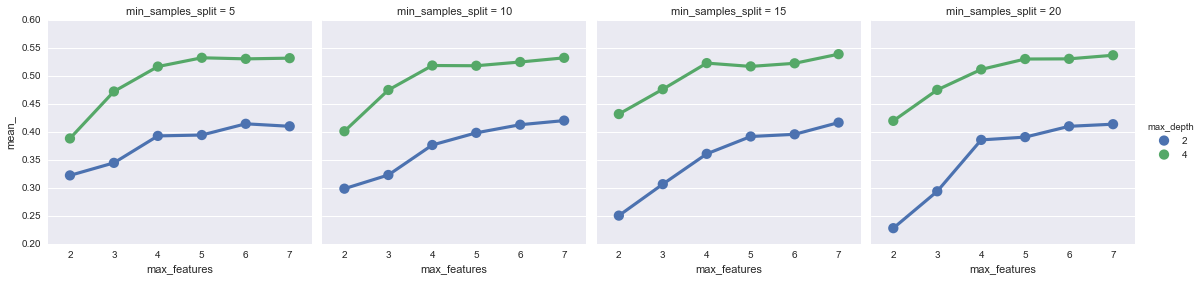

In [27]:
sns.factorplot(x='max_features', y='mean_', hue='max_depth', col='min_samples_split', data=scores)

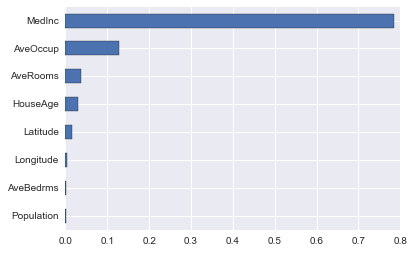

In [29]:
pd.Series(gs.best_estimator_.feature_importances_,
          index=X.columns).sort_values().plot(kind='barh')